In [3]:
import os 
import seaborn as sns
import pandas as pd
import numpy as np
#import hdbscan
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity as cos
from scipy.special import logit
from sklearn.cluster import SpectralClustering
from matplotlib.pyplot import figure
import matplotlib.style as style 
import copy
from matplotlib.pyplot import figure
from matplotlib import cm
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage


sns.set()
sns.set_style("white")

%load_ext autoreload
%autoreload 2

sns.set_style(
    'ticks', {
        'axes.grid': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'xtick.bottom': True,
        'ytick.left': True,
        'xtick.color': 'k',
        'ytick.color': 'k'
    })

sns.set_style("white")
style.use('ggplot')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42 #when saving as a pdf, do something with the background

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CHANGE DATA PATH

In [4]:
DATA_PATH = "/home/pdaly/temp/P_pca_logit-norf_gt-02.csv"
LABELS = "/home/kscangos/Sandbox/full_patient_list_pd_feb.csv"
P = pd.read_csv(DATA_PATH, index_col = 0).T

df = pd.read_csv('/home/pdaly/supereeg/data/apr6_100samp_2h_ml/df.csv', index_col=0)
depr_recs = list(set(df[df.dep ==1].index))

In [5]:
def sig(x):
    return 1/(1+np.exp(-x))

def occlude_feature_sensitivity(feature_list, X):
    """
    Return matrix with columns dropped from feature_list
    parameter: X pandas.DataFrame
    """
    assert type(X) == pd.DataFrame
    X_occ = X.drop(feature_list, axis=1)
    prob_occ = sig(X_occ.agg(sum,axis=1))
    prob_full = sig(X.agg(sum,axis=1))
    return prob_full - prob_occ


def plot_corr(samp, title, inds = np.array([]), size=(12,12), vmin=None, vmax=None):
    corr = samp.corr()
    if len(inds) == 0:
        inds = np.arange(corr.shape[0])
    elif inds == "ascending":
        means = np.mean(corr, axis=1)
        inds = np.argsort(means)
    elif inds == "descending":
        means = np.mean(corr, axis=1)
        inds = np.argsort(means)[::-1]
    corr = corr.values[np.ix_(inds, inds)]
    plt.figure(figsize=size)
    plt.matshow(corr, fignum=1, vmin=vmin, vmax=vmax)
    plt.xticks(range(samp.shape[1]), samp.columns[inds], fontsize=14, rotation=45)
    plt.yticks(range(samp.shape[1]), samp.columns[inds], fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=12)
    plt.grid()
    return plt.title(title, fontsize=16, y=1.15)

In [6]:
def plot_stacked_probabilities(pat_probs,title, xlabel, ylabel, color_order, save_dir = "",top=True, bottom=False, ax=None):
    """
    This method replaces the rather tedious and needlessly wordy cells that plotted 
    the activity bars. 
    This subroutine plots the result of occluding each cluster from the classification for each patient.
    
    Parameters
    ----------
    
        -pat_probs : pd.DataFrame with an index of the patient ids
            and the columns being the cluster activity contribution
            to probability of MDD classification
            
        - title : str of what you want to title the figure
        
        - xlabel : str label for the xaxis
        
        - ylabel : str label for the y axis
        
        - color_order : str codes for color coating each bar. First entry will be topmost bar
        
        - sav_dir : str location you want to save figures to
    """
    pat_neg_probs = pat_probs[pat_probs <0].fillna(0.0)
    pat_pos_probs = pat_probs[pat_probs >= 0].fillna(0.0)
    if ax is None:
        fig, ax = plt.subplots(figsize=[11,8])
    offset = 0
    if top:
        for i in range(len(pat_pos_probs.columns)):

            color = color_order[i]
            cols = list(range(0,len(pat_pos_probs.columns) - offset))
            sns.barplot(x = pat_pos_probs.index.values, y =pat_pos_probs.iloc[:,cols].sum(axis=1),\
                color = color, order = pat_pos_probs.index)
            offset += 1

   #overlaying negative vals
    offset = 0
    if bottom:
        for i in range(len(pat_neg_probs.columns)):
            color = color_order[i]
            cols = list(range(0,len(pat_pos_probs.columns) - offset))
            sns.barplot(x = pat_neg_probs.index.values, y =pat_neg_probs.iloc[:,cols].sum(axis=1),\
                color = color, order = pat_neg_probs.index)
            offset += 1 
    #saving figure

    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.set_ylim((-1,1))
    #if save_dir != "":
    #    plt.savefig(save_dir, transparent=True)



In [7]:
notkeep = np.abs(P).mean(axis=1) < 0.15
throw_out = notkeep[notkeep].index
P_sig = P.drop(throw_out)
# P_sig = P_sig.drop(['cluster'],axis=1)
P_sig_MDD = P_sig[depr_recs]

cos_sig = 1- cos(P_sig_MDD, P_sig_MDD)

In [8]:
P_sig

index,6,9,100,107,108,110,112,113,118,125,...,184,186,188,192,82,84,87,91,96,99
alpha_0,0.381811,0.261717,0.249801,0.064711,0.398494,0.181537,0.545952,-0.146591,-0.112446,-0.409082,...,-0.925584,-0.322246,-0.711294,0.065620,-0.272853,-0.244577,-0.353907,-0.018168,-0.268203,0.154841
alpha_1,-0.310004,-0.178241,-0.143558,-0.022128,-0.400089,-0.131943,-0.521874,0.143457,0.123164,0.499383,...,0.723548,0.083550,0.202188,-0.135175,0.381185,0.399867,0.516210,-0.056427,0.298540,-0.213511
alpha_2,0.424930,0.474714,0.281095,0.082435,0.399224,0.146161,0.428660,-0.055179,-0.081414,-0.257801,...,-0.869095,-0.210808,-0.589472,0.105957,-0.126089,-0.227264,-0.390814,-0.021902,-0.276570,-0.096733
alpha_4,-0.428536,-0.368333,-0.335748,-0.070612,-0.402875,-0.170616,-0.550217,0.054496,0.123535,0.539449,...,0.973196,0.180030,-0.041996,-0.180688,0.275490,0.375818,0.526711,-0.023853,0.326703,0.032823
alpha_5,-0.286684,-0.125038,-0.196601,-0.063629,-0.273341,-0.068545,-0.389997,0.048617,0.197233,0.288681,...,0.632876,-0.004323,0.181873,-0.100104,0.251093,0.241542,0.407616,-0.005014,0.206174,-0.142569
beta_0,0.167467,0.303972,0.153647,-0.040383,0.285933,-0.080784,0.450265,-0.094768,-0.256690,-0.063993,...,-0.273874,-0.658249,-0.046839,-0.125848,-0.184922,-0.389693,0.015786,0.016043,0.026920,0.177473
beta_1,-0.299048,-0.440004,-0.195805,0.142225,-0.445976,0.144531,-0.519615,0.159452,0.280503,0.305320,...,0.060066,0.363135,-0.056006,0.112513,0.306079,0.544083,0.243959,0.016312,0.101801,-0.270868
delta_0,0.181209,0.401553,0.136584,0.136885,0.520080,-0.148632,0.685698,-0.237137,-0.160207,-0.182585,...,-0.593465,-0.395986,-0.535913,0.094997,-0.167093,-0.417655,-0.242825,0.139816,0.013793,-0.195070
delta_1,-0.220020,-0.333525,-0.011516,-0.173861,-0.488346,0.264626,-0.479558,0.181755,0.109096,0.391935,...,0.342041,-0.070822,0.225592,-0.152212,0.220870,0.500228,0.381049,-0.146077,0.065242,0.346353
delta_2,0.208226,0.456004,0.193613,0.202735,0.407403,-0.134550,0.392051,-0.107264,-0.125835,-0.125101,...,-0.437081,-0.256929,-0.345276,0.107946,-0.065589,-0.361576,-0.199946,0.088216,-0.044486,-0.210656


# CHANGE THRESHOLD BELOW

In [9]:
P = pd.read_csv(DATA_PATH, index_col = 0).T
clusters = {0: ["beta_1", "alpha_4", "alpha_1", "alpha_5", "delta_1", "delta_4"],\
            1: ["theta_0","theta_2","theta_4", "beta_0", "delta_0", "delta_2", "alpha_0", "alpha_2"],\
        }
#clusters = {0: ['beta_2', 'alpha_5', 'alpha_2', 'alpha_6', 'delta_2', 'delta_5'],\
#            1: ['theta_1', 'theta_3', 'theta_5', 'beta_1', 'delta_1', 'delta_3', 'alpha_1', 'alpha_3'],\
#        }
cset = set(list(clusters[0])).union(set(list(clusters[1])))
og = set(P.index)
clust_2 = list(og.difference(cset))
clusters[2] = clust_2
cluster_dict = {}
for key in clusters:
    bands = clusters[key]
    for b in bands:
        cluster_dict[b] = key
P['cluster'] = [cluster_dict[ix] for ix in P.index]

In [10]:
# With just values > .15
Pf = pd.DataFrame(index=P.drop(["cluster"], axis=1).columns)
for clust in clusters:
    samp = P[P['cluster'] == clust].drop(["cluster"], axis=1)
    Pf['clust_{}_diff'.format(clust)] = occlude_feature_sensitivity(samp.T.columns, P.T.drop("cluster")) 
Pf.head()

,clust_0_diff,clust_1_diff,clust_2_diff
index,,,
6,-0.407440,0.153369,-0.004091
9,-0.274947,0.478612,0.033480
100,-0.252623,0.139627,0.037190
107,-0.063195,0.480337,-0.092640
108,-0.312123,0.522073,0.070479


In [11]:
P_sig_MDD["cluster"] =  [cluster_dict[val] for val in P_sig_MDD.index]
P_sig_MDD.head()

/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


index,132,136,9,142,143,150,155,159,166,175,...,84,87,91,96,100,107,108,118,125,cluster
alpha_0,0.065551,0.129354,0.261717,-0.186854,0.584124,0.086797,0.343364,0.267182,-0.141327,0.342795,...,-0.244577,-0.353907,-0.018168,-0.268203,0.249801,0.064711,0.398494,-0.112446,-0.409082,1
alpha_1,-0.181301,-0.030377,-0.178241,0.335154,-0.540337,-0.186595,-0.392938,-0.150877,0.278786,-0.352147,...,0.399867,0.516210,-0.056427,0.298540,-0.143558,-0.022128,-0.400089,0.123164,0.499383,0
alpha_2,-0.043092,0.253959,0.474714,-0.214304,0.387571,0.024972,0.345072,0.049615,-0.188322,0.319806,...,-0.227264,-0.390814,-0.021902,-0.276570,0.281095,0.082435,0.399224,-0.081414,-0.257801,1
alpha_4,0.176967,-0.203300,-0.368333,0.392190,-0.558070,-0.092805,-0.430649,-0.190017,0.313237,-0.291871,...,0.375818,0.526711,-0.023853,0.326703,-0.335748,-0.070612,-0.402875,0.123535,0.539449,0
alpha_5,0.003113,0.010559,-0.125038,0.193203,-0.478461,-0.163322,-0.311046,-0.081122,0.233293,-0.216177,...,0.241542,0.407616,-0.005014,0.206174,-0.196601,-0.063629,-0.273341,0.197233,0.288681,0


In [12]:
# # shift_thresh = 0
# # diff_df = pd.DataFrame(columns=["cluster", "diff","pat_index"])
clust_dict = {}

shift_thresh = 0
P = P_sig_MDD
diff_df = pd.DataFrame(columns=["cluster", "diff","pat_index"])

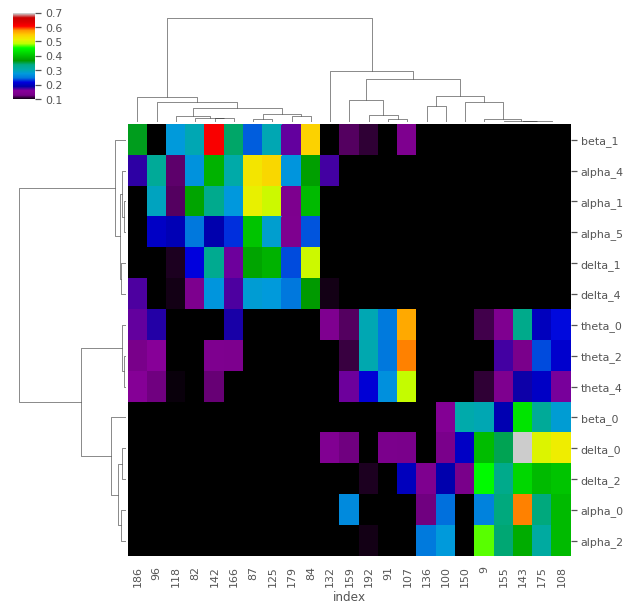

In [13]:
P_sig_MDDr = P_sig_MDD.drop(['cluster'], axis=1)
clust_map = sns.clustermap(P_sig_MDDr, vmin=.1, vmax=.7, metric="cosine",cmap="nipy_spectral")
#clust_map.savefig("/home/kscangos/paper_figs/hierarchical_graph-gt.pdf", transparent=True)

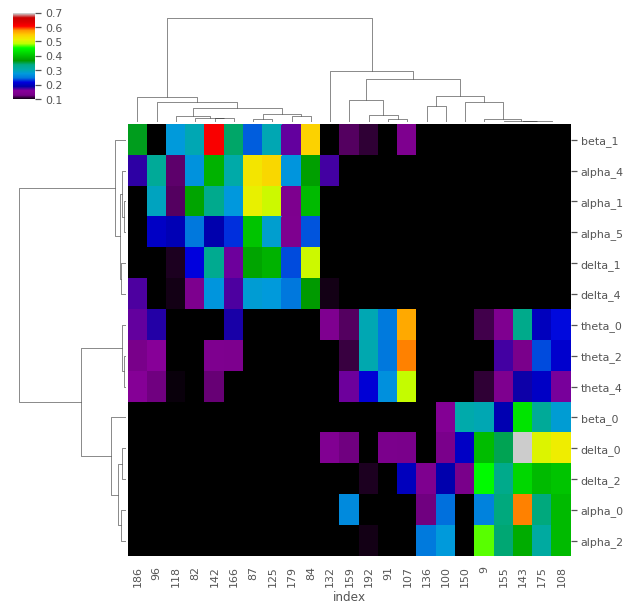

In [14]:
P_sig_MDDr = P_sig_MDD.drop(['cluster'], axis=1)
clust_map = sns.clustermap(P_sig_MDDr, vmin=.1, vmax=.7, metric="cosine",cmap="nipy_spectral")
#clust_map.savefig("/home/kscangos/paper_figs/hierarchical_graph-gt_015.pdf", transparent=True)

In [15]:
bt1_pids = [87, 125, 142, 84, 82, 166, 118, 96]
bt2_pids = [91, 192, 107, 108, 9, 175, 143]

In [16]:
P_sig_MDDr.T.shape

(23, 14)

In [17]:
#nep1_cols = ['beta_2', 'alpha_5', 'alpha_2', 'alpha_6', 'delta_2', 'delta_5']
#nep2_colcs = ['theta_1', 'theta_3', 'theta_5', 'beta_1', 'delta_1', 'delta_3', 'alpha_1', 'alpha_3']

In [18]:
nep1_cols = ['beta_1', 'alpha_4', 'alpha_1', 'alpha_5', 'delta_1', 'delta_4']
nep2_colcs = ['theta_0', 'theta_2', 'theta_4', 'beta_0', 'delta_0', 'delta_2', 'alpha_0', 'alpha_2']

In [19]:
Pf = Pf.sort_values(['clust_0_diff'])
Pf_MDD = Pf[Pf.index.isin(depr_recs)]
PF_norm = Pf[~Pf.index.isin(depr_recs)]

In [20]:
PF_norm

,clust_0_diff,clust_1_diff,clust_2_diff
index,,,
148,-0.517545,0.356853,0.098330
178,-0.413898,0.187505,0.040298
6,-0.407440,0.153369,-0.004091
112,-0.388295,0.483977,0.106519
182,-0.153477,0.077190,0.100569
139,-0.114970,-0.018075,0.064037
133,-0.051085,0.166105,0.068964
99,-0.000494,-0.003928,-0.316694
137,0.000413,0.156276,-0.049470


<Figure size 432x288 with 0 Axes>

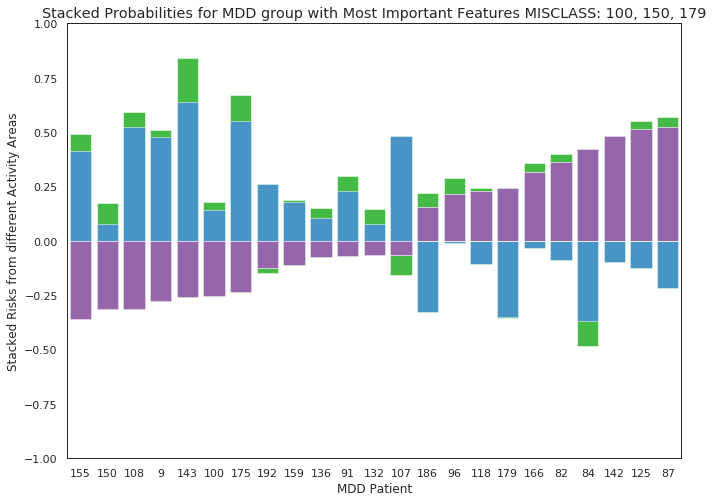

In [21]:
title = "Stacked Probabilities for MDD group with Most Important Features MISCLASS: 100, 150, 179"
xlabel = "MDD Patient"
ylabel = 'Stacked Risks from different Activity Areas'
color = ["#32CD32","#3498db","#9b59b6","#e74c3c"]  #"#34495e","#95a5a6" 
sns.set_style("white")
sns.despine()
plt.tight_layout()
plot_stacked_probabilities(Pf_MDD,title, xlabel, ylabel,color, bottom=True)#, save_dir='/home/kscangos/Sandbox/stacked_probs_MDD_sig.pdf')

<Figure size 432x288 with 0 Axes>

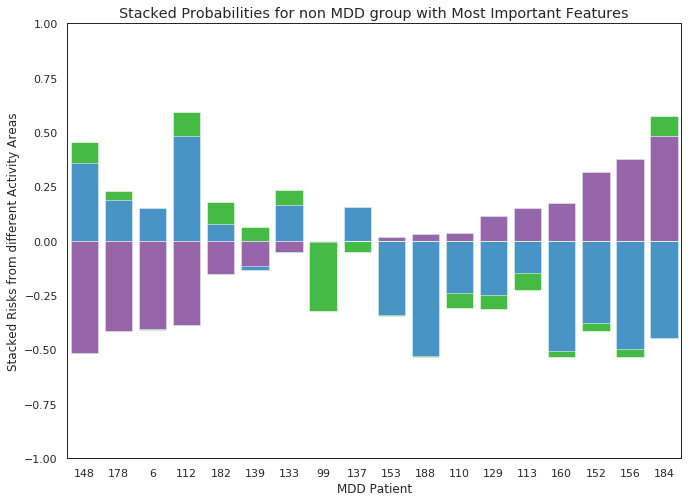

In [22]:
title = "Stacked Probabilities for non MDD group with Most Important Features"
xlabel = "MDD Patient"
ylabel = 'Stacked Risks from different Activity Areas'
color = ["#32CD32","#3498db","#9b59b6","#e74c3c"]  #"#34495e","#95a5a6" 
sns.set_style("white")
sns.despine()
plt.tight_layout()
plot_stacked_probabilities(PF_norm,title, xlabel, ylabel,color, bottom =True)#, save_dir='/home/kscangos/Sandbox/stacked_probs_noMDD_sig.pdf')

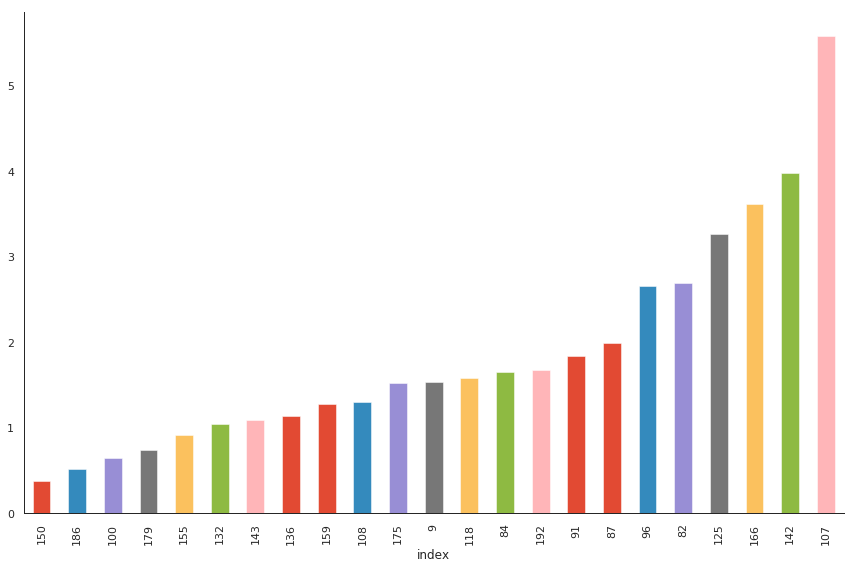

In [23]:
# odds ratio
fig, ax = plt.subplots(figsize=(12, 8))
P.drop('cluster', axis=1).T.sum(axis=1).apply(np.exp).sort_values().plot(kind='bar')
sns.despine();
plt.tight_layout()
#plt.savefig("/home/kscangos/Sandbox/oddsratio.pdf", transparent=True)

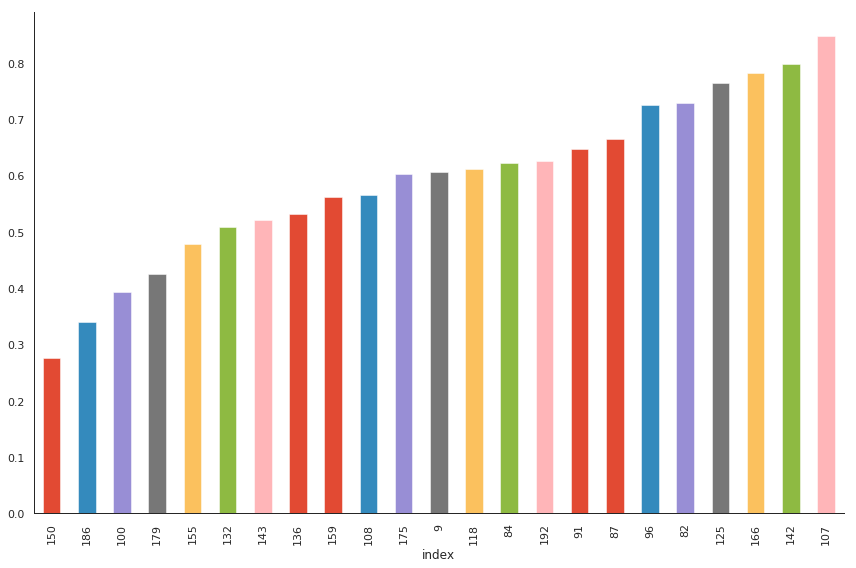

In [24]:
# probability
fig, ax = plt.subplots(figsize=(12, 8))
P.drop('cluster', axis=1).T.sum(axis=1).apply(lambda x: 1 / (1 + np.exp(-x))).sort_values().plot(kind='bar')
sns.despine();
plt.tight_layout()
#plt.savefig("/home/kscangos/Sandbox/prob.pdf", transparent=True)

In [25]:
P.drop('cluster', axis=1).T.sum(axis=1).apply(lambda x: 1 / (1 + np.exp(-x))).sort_values()

index
150    0.275314
186    0.340300
100    0.392725
179    0.425286
155    0.477733
132    0.509112
143    0.520552
136    0.531727
159    0.561306
108    0.565448
175    0.602904
9      0.605907
118    0.612006
84     0.623077
192    0.626526
91     0.647545
87     0.664925
96     0.726219
82     0.728587
125    0.765115
166    0.783380
142    0.799027
107    0.847828
dtype: float64

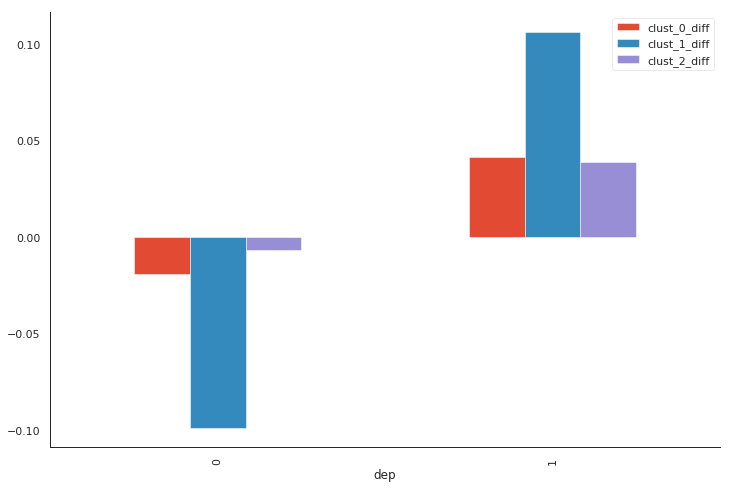

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
Pfg = Pf.join(df.dep)
Pfg.groupby('dep').mean().plot(kind='bar', ax=ax);
sns.despine();

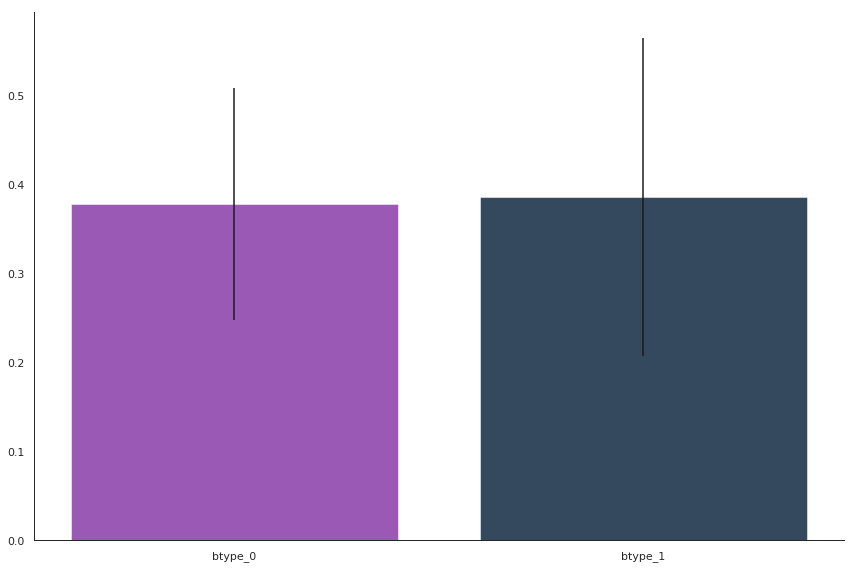

In [27]:
#btypes = {
#    0: [186, 96, 118, 82, 142, 166, 87, 125, 179, 84],
#    1: [132, 159, 192, 91, 107, 136, 150, 100, 9, 155, 143, 175, 108]
#}
btypes = {
    0: [87, 125, 142, 82, 166, 118, 96],
    1: [136, 159, 91, 192, 155, 9, 107, 108, 175, 143]
}

fig, ax = plt.subplots(figsize=(12, 8))
btype0 = Pfg.loc[btypes[0]].clust_0_diff.mean()
btype0_std = Pfg.loc[btypes[0]].clust_0_diff.std()
btype1 = Pfg.loc[btypes[1]].clust_1_diff.mean()
btype1_std = Pfg.loc[btypes[1]].clust_1_diff.std()

plt.bar(['btype_0', 'btype_1'], [btype0, btype1], 
        yerr=[btype0_std, btype1_std], color=["#9b59b6", "#34495e"])

sns.despine();
plt.tight_layout();

#plt.savefig("/home/kscangos/Sandbox/btype_nep_contribution.pdf", transparent=True)

<BarContainer object of 2 artists>

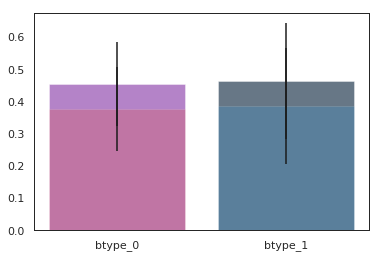

In [28]:
plt.bar(['btype_0', 'btype_1'], [btype0*1.2, btype1*1.2], 
        yerr=[btype0_std, btype1_std], color=["#9b59b6", "#34495e"], alpha=0.75)
plt.bar(['btype_0', 'btype_1'], [btype0, btype1], 
        yerr=[btype0_std, btype1_std], color=["#e74c3c","#3498db"], alpha=0.25)

<Figure size 432x288 with 0 Axes>

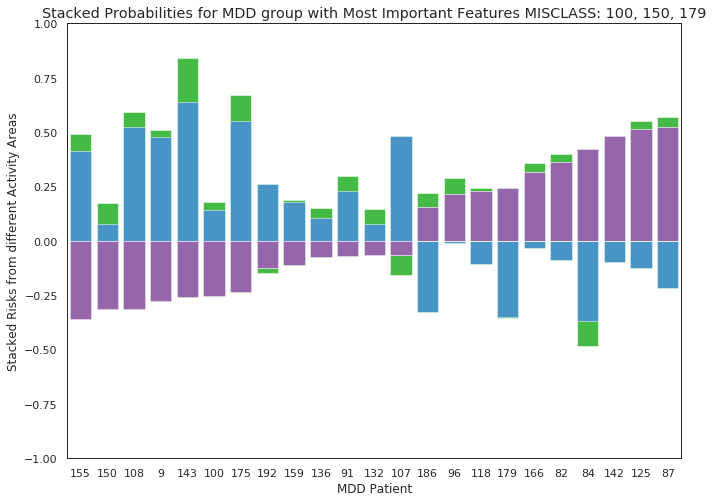

In [29]:
title = "Stacked Probabilities for MDD group with Most Important Features MISCLASS: 100, 150, 179"
xlabel = "MDD Patient"
ylabel = 'Stacked Risks from different Activity Areas'
color = ["#32CD32","#3498db","#9b59b6","#e74c3c"]  #"#34495e","#95a5a6" 
sns.set_style("white")
sns.despine()
plt.tight_layout()
plot_stacked_probabilities(Pf_MDD, title, xlabel, ylabel,color, bottom=True)

In [30]:
probas = pd.read_csv('~/temp/preds_pca-logit.csv', index_col=0)

In [31]:
probas

,proba,actual,pred,match
index,,,,
99,0.005697,0,0,True
188,0.016528,0,0,True
153,0.065206,0,0,True
160,0.072152,0,0,True
110,0.100291,0,0,True
129,0.160942,0,0,True
152,0.246997,0,0,True
150,0.252314,1,0,False
6,0.261867,0,0,True


In [32]:
# missclassified
probas[(probas.match == False) & (probas.actual == 1)]

,proba,actual,pred,match
index,,,,
150,0.252314,1,0,False
179,0.282413,1,0,False
100,0.305462,1,0,False
84,0.411901,1,0,False


/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

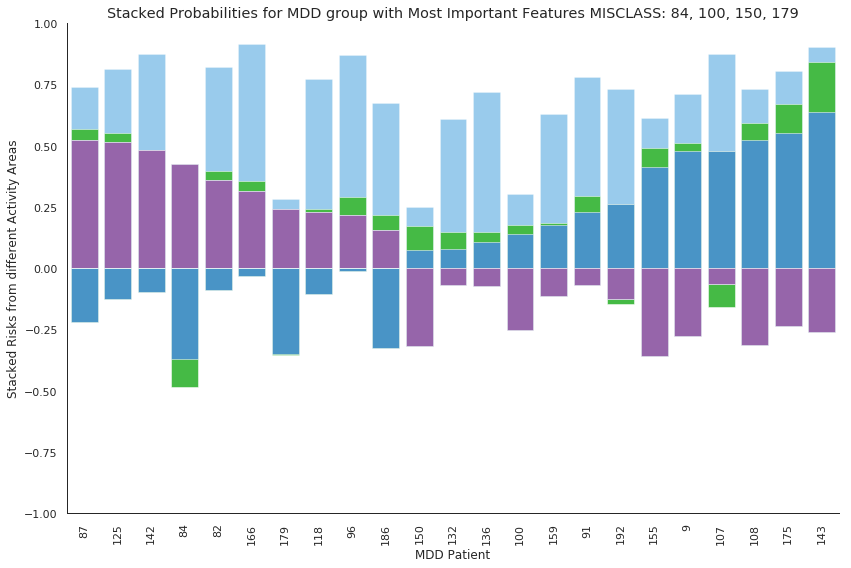

In [33]:
Pf_MDD['btype'] = Pf_MDD['clust_0_diff'].apply(lambda d:
                'bt_1' if d >= 0 else 'bt_2')
temp = pd.concat([
    Pf_MDD[Pf_MDD['btype'] == 'bt_1'].sort_values('clust_0_diff', ascending=False),
    Pf_MDD[Pf_MDD['btype'] == 'bt_2'].sort_values('clust_1_diff', ascending=True)]
).drop('btype', axis=1)

#title = "Stacked Probabilities for MDD group with Most Important Features MISCLASS: 100, 150, 179"
title = "Stacked Probabilities for MDD group with Most Important Features MISCLASS: 84, 100, 150, 179"
xlabel = "MDD Patient"
ylabel = 'Stacked Risks from different Activity Areas'

color = ["#32CD32","#3498db","#9b59b6","#e74c3c"]  #"#34495e","#95a5a6" 
sns.set_style("white")
sns.despine()

fig, ax = plt.subplots(figsize=(12, 8))

ps = probas.loc[temp.index, 'proba']
#sns.barplot(x=ps.index, y=ps.values, color="#3498db", alpha=0.5, ax=ax)
ps.plot(kind='bar', width=0.8, color="#3498db", alpha=0.5, ax=ax)
plot_stacked_probabilities(temp, title, xlabel, ylabel,color, bottom=True, ax=ax)

plt.tight_layout()
sns.despine();

#plt.savefig("../temp/nep_and_probas_barchart-mdd_aug20.pdf", transparent=True)

/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

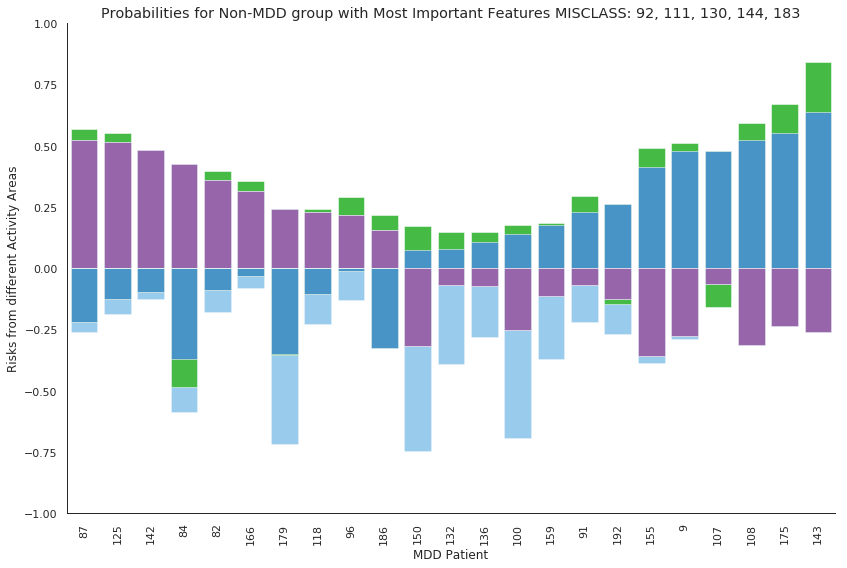

In [46]:
PF_norm['btype'] = PF_norm['clust_0_diff'].apply(lambda d:
                'bt_1' if d >= 0 else 'bt_2')
temp1 = pd.concat([
    PF_norm[PF_norm['btype'] == 'bt_1'].sort_values('clust_0_diff', ascending=False),
    PF_norm[PF_norm['btype'] == 'bt_2'].sort_values('clust_1_diff', ascending=True)]
).drop('btype', axis=1)

title = "Probabilities for Non-MDD group with Most Important Features MISCLASS: 92, 111, 130, 144, 183"
xlabel = "MDD Patient"
ylabel = 'Risks from different Activity Areas'

color = ["#32CD32","#3498db","#9b59b6","#e74c3c"]  #"#34495e","#95a5a6" 
sns.set_style("white")
sns.despine()

fig, ax = plt.subplots(figsize=(12, 8))

ps = -(1-(probas.loc[temp.index, 'proba']))
#sns.barplot(x=ps.index, y=ps.values, color="#3498db", alpha=0.5, ax=ax)
ps.plot(kind='bar', width=0.8, color="#3498db", alpha=0.5, ax=ax)
plot_stacked_probabilities(temp, title, xlabel, ylabel,color, bottom=True, ax=ax)

plt.tight_layout()
sns.despine();

#plt.savefig("../temp/nep_and_probas_barchart-no_mdd_oct14-boundary.pdf", transparent=True)

In [34]:
#bt1_pids = [87, 125, 142, 84, 82, 166, 118, 96]
#bt2_pids = [91, 192, 107, 108, 9, 175, 143]
bt1_pids = [87, 125, 142, 82, 166, 118, 96]
bt2_pids = [136, 159, 91, 192, 155, 9, 107, 108, 175, 143]

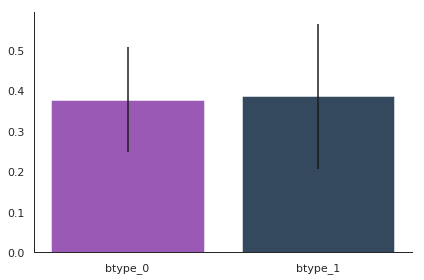

In [35]:
bts = pd.DataFrame(pd.concat([temp.loc[bt1_pids, 'clust_0_diff'], 
                 temp.loc[bt2_pids, 'clust_1_diff']]), columns=['diff'])
bts['btype'] = ['bt1'] * 7 + ['bt2'] * 10
means = bts.groupby('btype').mean().values.T.tolist()[0]
stds = bts.groupby('btype').std().values.T.tolist()[0]
plt.bar(['btype_0', 'btype_1'], means, yerr=stds, color=["#9b59b6", "#34495e"])

sns.despine();
plt.tight_layout()

#plt.savefig('/home/pdaly/temp/btype_bar.pdf', transparent=True)

In [36]:
means

[0.37792723497395003, 0.38642970679412353]

In [37]:
pd.DataFrame([means, stds], index=['means', 'stds'], columns=['bt1', 'bt2'])

,bt1,bt2
means,0.377927,0.386430
stds,0.130282,0.178954


In [38]:
PF_norm['btype'] = PF_norm['clust_0_diff'].apply(lambda d:
                'bt_1' if d >= 0 else 'bt_2')

/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
# missclassified
probas[(probas.match == False) & (probas.actual == 0)]

,proba,actual,pred,match
index,,,,
112,0.503327,0,1,False
184,0.511980,0,1,False
137,0.656114,0,1,False
133,0.842720,0,1,False


In [40]:
pwd

'/home/pdaly/notebooks'

In [49]:
labels = pd.read_csv(LABELS).rename(columns={'Unnamed: 0': 'pid'})

In [50]:
labels['pid_num'] = labels.pid.apply(lambda p: int(p[2:]))

In [51]:
tf = pd.concat([temp, temp1])

In [52]:
tf = tf.merge(labels, left_index=True, right_on='pid_num', how='left')

In [96]:
tfl5 = tf[tf['phq-9'] <= 5].set_index('pid_num')

In [97]:
tfl5

,clust_0_diff,clust_1_diff,clust_2_diff,pid,sub,dep,phq-9,sex(M=1),tle,ho_mdd,antid,gaba,mstab
pid_num,,,,,,,,,,,,,
184,0.481926,-0.446419,0.091518,EC184,55,0,2,1,0.0,1.0,0.0,0.0,1.0
156,0.374950,-0.495882,-0.039853,EC156,42,0,4,1,1.0,0.0,0.0,1.0,0.0
152,0.318950,-0.377574,-0.036487,EC152,39,0,5,0,0.0,1.0,0.0,1.0,1.0
160,0.173128,-0.505584,-0.026903,EC160,44,0,2,0,1.0,0.0,0.0,0.0,1.0
113,0.150767,-0.149512,-0.075206,EC113,27,0,2,1,1.0,1.0,0.0,0.0,1.0
129,0.115358,-0.248901,-0.065038,EC129,30,0,4,0,0.0,0.0,0.0,0.0,1.0
110,0.034853,-0.241015,-0.068589,EC110,24,0,5,0,0.0,0.0,0.0,0.0,1.0
188,0.032920,-0.530306,-0.004749,EC188,57,0,3,1,0.0,0.0,0.0,1.0,1.0
153,0.019763,-0.342410,-0.001304,EC153,40,0,2,1,1.0,0.0,0.0,0.0,1.0


In [99]:
from IPython.display import display

In [100]:
# green   darker blue  purple

In [101]:
tbl = {'clust_0_diff': 'purple', 'clust_1_diff': 'dark_blue', 'clust_2_diff': 'green'}
cols = list(tbl.values())

In [102]:
tfl5 = tfl5.rename(columns=tbl)[cols]

In [103]:
prl5 = probas.loc[tfl5.index.values]
prl5

,proba,actual,pred,match
index,,,,
184,0.511980,0,1,False
156,0.416137,0,0,True
152,0.246997,0,0,True
160,0.072152,0,0,True
113,0.301303,0,0,True
129,0.160942,0,0,True
110,0.100291,0,0,True
188,0.016528,0,0,True
153,0.065206,0,0,True


In [104]:
tfl5[tfl5.purple > 0]

,purple,green,dark_blue
pid_num,,,
184,0.481926,0.091518,-0.446419
156,0.374950,-0.039853,-0.495882
152,0.318950,-0.036487,-0.377574
160,0.173128,-0.026903,-0.505584
113,0.150767,-0.075206,-0.149512
129,0.115358,-0.065038,-0.248901
110,0.034853,-0.068589,-0.241015
188,0.032920,-0.004749,-0.530306
153,0.019763,-0.001304,-0.342410


In [105]:
tfl5[tfl5.purple < 0]

,purple,green,dark_blue
pid_num,,,
139,-0.114970,0.064037,-0.018075
99,-0.000494,-0.316694,-0.003928
182,-0.153477,0.100569,0.077190
6,-0.407440,-0.004091,0.153369
133,-0.051085,0.068964,0.166105
178,-0.413898,0.040298,0.187505
148,-0.517545,0.098330,0.356853
112,-0.388295,0.106519,0.483977


In [ ]:
# plot average 
g1 = [156, 160, 113, 129, 188, 153]
g2 = [139, 182, 6, 178, 148]
mix = [113, 99, 139]
missed = [184, 137, 133, 112]

In [109]:
prl5[prl5.match]

,proba,actual,pred,match
index,,,,
156,0.416137,0,0,True
152,0.246997,0,0,True
160,0.072152,0,0,True
113,0.301303,0,0,True
129,0.160942,0,0,True
110,0.100291,0,0,True
188,0.016528,0,0,True
153,0.065206,0,0,True
139,0.405071,0,0,True


In [110]:
prl5[~prl5.match]

,proba,actual,pred,match
index,,,,
184,0.511980,0,1,False
137,0.656114,0,1,False
133,0.842720,0,1,False
112,0.503327,0,1,False


In [108]:
tfl5.shape

(18, 3)

In [192]:
tfl5.loc[g1, 'group'] = 'Group-1'
tfl5.loc[g2, 'group'] = 'Group-2'
tfl5.loc[missed, 'group'] = 'Missclassified'

In [193]:
nf = tfl5.rename(columns={'purple': 'nep_1', 'dark_blue': 'nep_2'}).drop('green', axis=1)

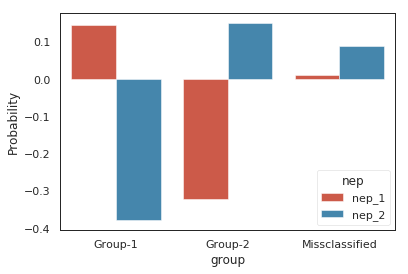

In [194]:
sns.barplot(x='group', y='Probability', hue='nep', 
            data=nf[nf.group.notnull()].groupby('group').mean().unstack().to_frame().reset_index().rename(
                    columns={'level_0': 'nep', 0: 'Probability'}))

In [195]:
nf[nf.group.notnull()].reset_index().set_index(['pid_num', 'group']).stack().to_frame().reset_index()\
            .rename(columns={'level_2': 'nep', 0: 'Probability'}).groupby(['group', 'nep']).agg(['mean', 'std'])

pid_num            Probability          
                            mean        std        mean       std
group          nep                                               
Group-1        nep_1  149.833333  26.072335    0.144481  0.128705
               nep_2  149.833333  26.072335   -0.378766  0.157167
Group-2        nep_1  130.600000  72.088834   -0.321466  0.176949
               nep_2  130.600000  72.088834    0.151368  0.139416
Missclassified nep_1  141.500000  30.380915    0.010740  0.358318
               nep_2  141.500000  30.380915    0.089985  0.388650

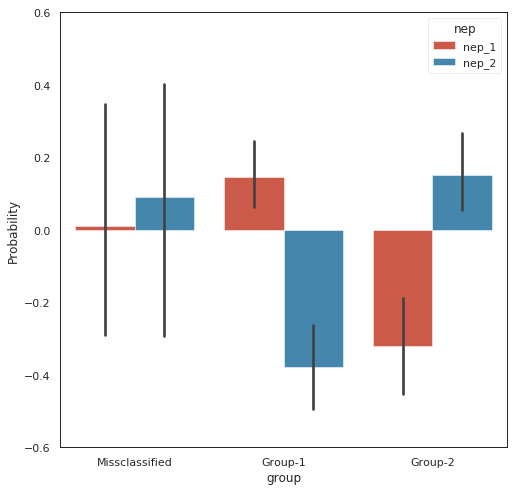

In [197]:
plt.subplots(figsize=(8, 8))
sns.barplot(x='group', y='Probability', hue='nep',
            data=nf[nf.group.notnull()].reset_index().set_index(['pid_num', 'group']).stack().to_frame().reset_index()\
            .rename(columns={'level_2': 'nep', 0: 'Probability'}))

plt.ylim([-0.6, 0.6])

plt.savefig("../temp/nep_barchart_both_groups-less_than_5_with_missclassified.pdf", transparent=True)

In [168]:
pd.DataFrame.set_index?

In [ ]:
nf[nf.group.notnull()].set_index

In [155]:
nf[nf.group.notnull()].groupby('group').mean()

,nep_1,nep_2
group,,
Group-1,0.144481,-0.378766
Group-2,-0.321466,0.151368


TypeError: only size-1 arrays can be converted to Python scalars

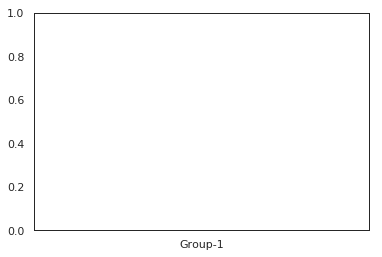

In [123]:
means = tfl5.groupby('group').mean().values.T.tolist()
stds = tfl5.groupby('group').std().values.T.tolist()
plt.bar(['Group-1', 'Group-2'], means, yerr=stds, color=["#9b59b6", "#34495e"])

sns.despine()

,green,purple,dark_blue
pid_num,,,
182,-0.153477,0.100569,0.077190
139,-0.114970,0.064037,-0.018075
133,-0.051085,0.068964,0.166105
178,-0.413898,0.040298,0.187505
148,-0.517545,0.098330,0.356853


green       -0.250195
purple       0.074440
dark_blue    0.153916
dtype: float64

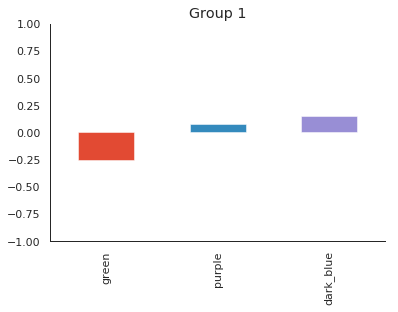

In [74]:
display(tfl5.loc[g1])
display(tfl5.loc[g1].mean())
display(tfl5.loc[g1].mean().plot(kind='bar'))

plt.ylim([-1, 1])
plt.title('Group 1')

sns.despine()

#plt.savefig("../temp/nep_barchart_group1-less_than_5.pdf", transparent=True)

,green,purple,dark_blue
pid_num,,,
156,0.374950,-0.039853,-0.495882
160,0.173128,-0.026903,-0.505584
129,0.115358,-0.065038,-0.248901
188,0.032920,-0.004749,-0.530306
153,0.019763,-0.001304,-0.342410
6,-0.407440,-0.004091,0.153369


green        0.051447
purple      -0.023656
dark_blue   -0.328286
dtype: float64

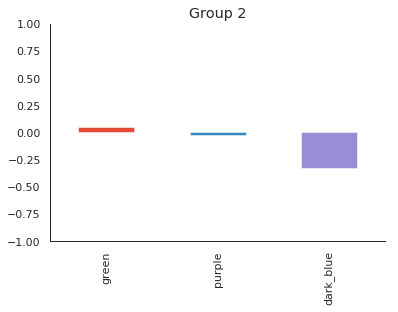

In [77]:
display(tfl5.loc[g2])
display(tfl5.loc[g2].mean())
display(tfl5.loc[g2].mean().plot(kind='bar'))

plt.ylim([-1, 1])
plt.title('Group 2')

sns.despine()

plt.savefig("../temp/nep_barchart_group2-less_than_5.pdf", transparent=True)

,green,purple,dark_blue
pid_num,,,
113,0.150767,-0.075206,-0.149512
99,-0.000494,-0.316694,-0.003928
139,-0.114970,0.064037,-0.018075


green        0.011767
purple      -0.109287
dark_blue   -0.057171
dtype: float64

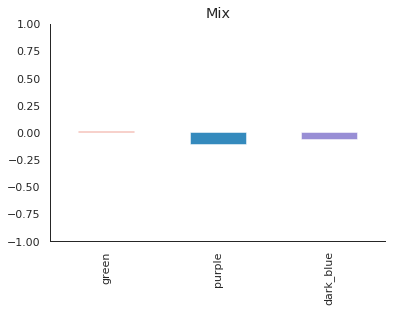

In [80]:
display(tfl5.loc[mix])
display(tfl5.loc[mix].mean())
display(tfl5.loc[mix].mean().plot(kind='bar'))

plt.ylim([-1, 1])
plt.title('Mix')

sns.despine()

plt.savefig("../temp/nep_barchart_mix-less_than_5.pdf", transparent=True)

In [199]:
import pickle
pmdd = pickle.load(open('/home/pdaly/temp/pmdd.pkl', 'rb'))

In [200]:
pmdd

{'bt1':        clust_0_diff  clust_1_diff  clust_2_diff
 index                                          
 87         0.522804     -0.218088      0.046424
 125        0.514453     -0.124018      0.036448
 142        0.481294     -0.095968      0.000578
 82         0.362692     -0.089443      0.035566
 166        0.316375     -0.030589      0.040424
 118        0.230262     -0.104608      0.013970
 96         0.217610     -0.012076      0.073279,
 'bt2':        clust_0_diff  clust_1_diff  clust_2_diff
 index                                          
 136       -0.072107      0.107160      0.043056
 159       -0.111457      0.178905      0.007882
 91        -0.069383      0.230008      0.067273
 192       -0.123548      0.261819     -0.023987
 155       -0.357775      0.415316      0.077332
 9         -0.274947      0.478612      0.033480
 107       -0.063195      0.480337     -0.092640
 108       -0.312123      0.522073      0.070479
 175       -0.234450      0.552681      0.118734
 143 

In [205]:
tfl5.loc[g1]

,purple,green,dark_blue,group
pid_num,,,,
156,0.374950,-0.039853,-0.495882,Group-1
160,0.173128,-0.026903,-0.505584,Group-1
113,0.150767,-0.075206,-0.149512,Group-1
129,0.115358,-0.065038,-0.248901,Group-1
188,0.032920,-0.004749,-0.530306,Group-1
153,0.019763,-0.001304,-0.342410,Group-1


In [206]:
tfl5.loc[g2]

,purple,green,dark_blue,group
pid_num,,,,
139,-0.114970,0.064037,-0.018075,Group-2
182,-0.153477,0.100569,0.077190,Group-2
6,-0.407440,-0.004091,0.153369,Group-2
178,-0.413898,0.040298,0.187505,Group-2
148,-0.517545,0.098330,0.356853,Group-2
